In [48]:
# ECE 247A - Design Matrix
# imports
import numpy as np
import matplotlib.pyplot as plt

import scienceplots
import shutup

from glm import build_model
from data import add_sigmoid_params

%load_ext autoreload
%autoreload 2

# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib widget

# suppress warnings :-)
shutup.please()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# TODO: 
# 2. add continuous svd *
# 3. add search to neuronviewer

In [49]:
# Load data

trial_data_all = np.load("../vars/trial_data_all_MM012_MM013_all5.npz", allow_pickle=True)['arr_0']
session_data_all = np.load("../vars/session_data_all_MM012_MM013_all5.npz", allow_pickle=True)['arr_0']
unit_spike_times_all = np.load("../vars/unit_spike_times_all_MM012_MM013_all5.npz", allow_pickle=True)['arr_0']
regions_all = np.load("../vars/regions_all_MM012_MM013_all5.npz", allow_pickle=True)['arr_0']

MB_sig_sess = np.load("../vars/MB_sigs_sess.npz", allow_pickle=True)['arr_0']
MF_sig_sess = np.load("../vars/MF_sigs_sess.npz", allow_pickle=True)['arr_0']

subj_idx=0; sess_idx=0 # 0 and 9

trial_data = trial_data_all[subj_idx][sess_idx]
session_data = session_data_all[subj_idx][sess_idx]
spike_times = unit_spike_times_all[subj_idx][sess_idx]['ACC']
mb_sigms = MB_sig_sess[sess_idx]
mf_sigms = MF_sig_sess[sess_idx]

trial_data = add_sigmoid_params(trial_data, session_data, mb_sigms, mf_sigms)

In [60]:
# Make design matrix

BWMS = 100
binwidth_s = BWMS/1000

responded = (trial_data['response']==1) | (trial_data['response']==-1)
master_alignment_times = trial_data['task_start_time'] + trial_data['response_time']
master_alignment_times = master_alignment_times[responded].values

pres = 1
posts = 2
bwidth = BWMS / 1000

dmat = build_model(master_alignment_times, trial_data, pres=pres, posts=posts, bwidth=binwidth_s)
dmat.build_matrix()
X = dmat.X

Building regressor: "right_choice"
Building regressor: "left_choice"
Building regressor: "reward"
Building regressor: "punish"
Building regressor: "right_choice_correct"
Building regressor: "right_choice_incorrect"
Building regressor: "left_choice_correct"
Building regressor: "left_choice_incorrect"


In [61]:
# verify the cell responds to right contrasts

from DAMN.damn.alignment import compute_spike_count
from spks.viz import plot_event_aligned_raster
from spks.utils import gaussian_function

r_mask = (trial_data[responded]['response']==-1)
l_mask = (trial_data[responded]['response']==1)
w_mask = (trial_data[responded]['rewarded']==1)
p_mask = (trial_data[responded]['rewarded']==0)

all = []
all_l = []
all_r = []
all_w = []
all_p = []
for s in spike_times:
    peth, timebin_centers, event_ind       = compute_spike_count(master_alignment_times, s, pre_seconds=pres, post_seconds=posts, binwidth_s=BWMS/1000)
    peth_l, timebin_centers_l, event_ind_l = compute_spike_count(master_alignment_times[l_mask], s, pre_seconds=pres, post_seconds=posts, binwidth_s=BWMS/1000)
    peth_r, timebin_centers_r, event_ind_r = compute_spike_count(master_alignment_times[r_mask], s, pre_seconds=pres, post_seconds=posts, binwidth_s=BWMS/1000)
    peth_w, timebin_centers_w, event_ind_w = compute_spike_count(master_alignment_times[w_mask], s, pre_seconds=pres, post_seconds=posts, binwidth_s=BWMS/1000)
    peth_p, timebin_centers_p, event_ind_p = compute_spike_count(master_alignment_times[p_mask], s, pre_seconds=pres, post_seconds=posts, binwidth_s=BWMS/1000)
    
    all.append(peth)
    all_l.append(peth_l)
    all_r.append(peth_r)
    all_w.append(peth_w)
    all_p.append(peth_p)
    
peth = np.stack(all)
peth_l = np.stack(all_l)
peth_r = np.stack(all_r)
peth_w = np.stack(all_w)
peth_p = np.stack(all_p)

n_units, n_trials, samples_per_trial = peth.shape
_, n_trials_l, _ = peth_l.shape
_, n_trials_r, _ = peth_r.shape
_, n_trials_w, _ = peth_w.shape # w stands for water... rewarded overloads r for right
_, n_trials_p, _ = peth_p.shape

print("num trials: ", n_trials, 
      ", num left trials: ", n_trials_l, 
      ", num right trials: ", n_trials_r, 
      ", num rewarded trials: ", n_trials_w,
      ", num punished trials: ", n_trials_p,
      ", samples per trial: ", samples_per_trial)
Y = np.reshape(peth, (n_units, n_trials*samples_per_trial,), order='C').T
print("X shape: ", X.shape, ", Y shape: ", Y.shape)

num trials:  336 , num left trials:  179 , num right trials:  157 , num rewarded trials:  203 , num punished trials:  133 , samples per trial:  29
X shape:  (9744, 84) , Y shape:  (9744, 79)


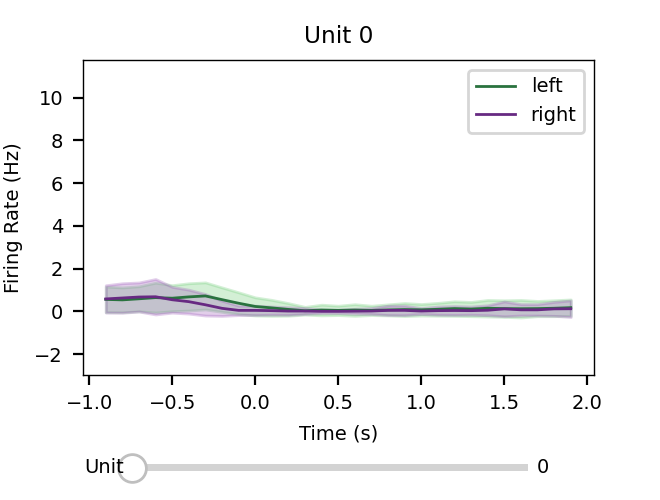

In [52]:
from neuron_viewer import *
from renderers import *

# r_grand = PETHRenderer(peth, pres, posts, binwidth_s, mode="grand")
# viewer_grand = NeuronViewer(num_units=peth.shape[0], render_func=r_grand, ymin=r_grand.ymin, ymax=r_grand.ymax)

r_choice = PETHRenderer(
    peth_a=peth_l,
    peth_b=peth_r,
    mode="cond",
    label_a="left",
    label_b="right"
)
viewer_choice = NeuronViewer(num_units=peth.shape[0], render_func=r_choice, ymin=r_choice.ymin, ymax=r_choice.ymax)


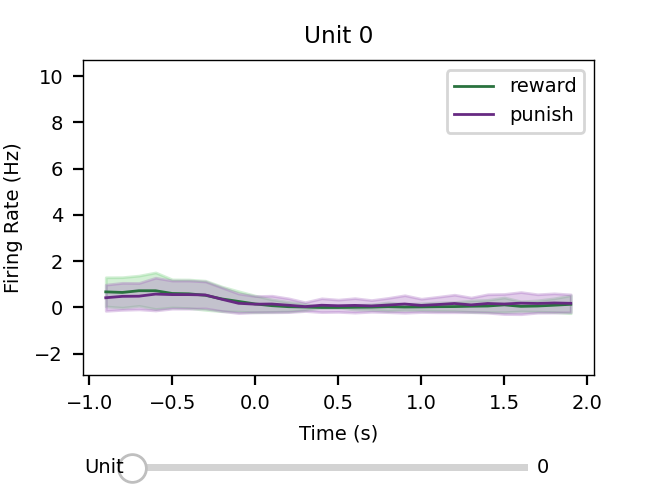

In [43]:

r_fback = PETHRenderer(
    peth_a=peth_w,
    peth_b=peth_p,
    mode="cond",
    label_a="reward",
    label_b="punish"
)
viewer_fback = NeuronViewer(num_units=peth.shape[0], render_func=r_fback, ymin=r_fback.ymin, ymax=r_fback.ymax)

In [62]:
from sklearn.linear_model import PoissonRegressor, Ridge, LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# now fit models and get coefficients back
model = PoissonRegressor(alpha=0)
model = MultiOutputRegressor(PoissonRegressor(alpha=1e-7,max_iter=10000), n_jobs=1) #TODO: penalize
#model = LinearRegression()
model.fit(X, Y)
#coefs = model.coef_.flatten()
bias = [m.intercept_ for m in model.estimators_]
coefs = [np.array(m.coef_).flatten() for m in model.estimators_]
bias = np.squeeze(bias)
if np.ndim(bias) == 0:
    bias = np.array([bias])
coefs = np.stack(coefs)

print(Y.shape, X.shape, coefs.T.shape)

dmat.set_coefficients(coefs.T)

(9744, 79) (9744, 84) (84, 79)


In [ ]:
from renderers import *

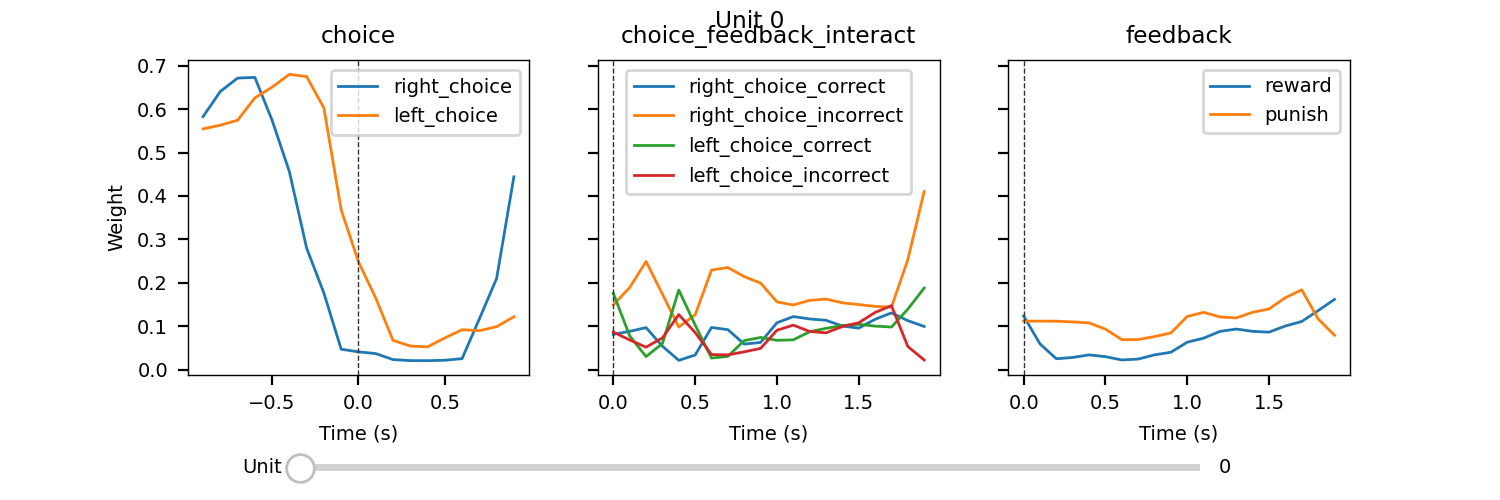

In [63]:
r_kernel = KernelRenderer(model, dmat, bias)
viewer_kernels = NeuronViewer(num_units=peth.shape[0], render_func=r_kernel, ncols=len(r_kernel.all_tags))


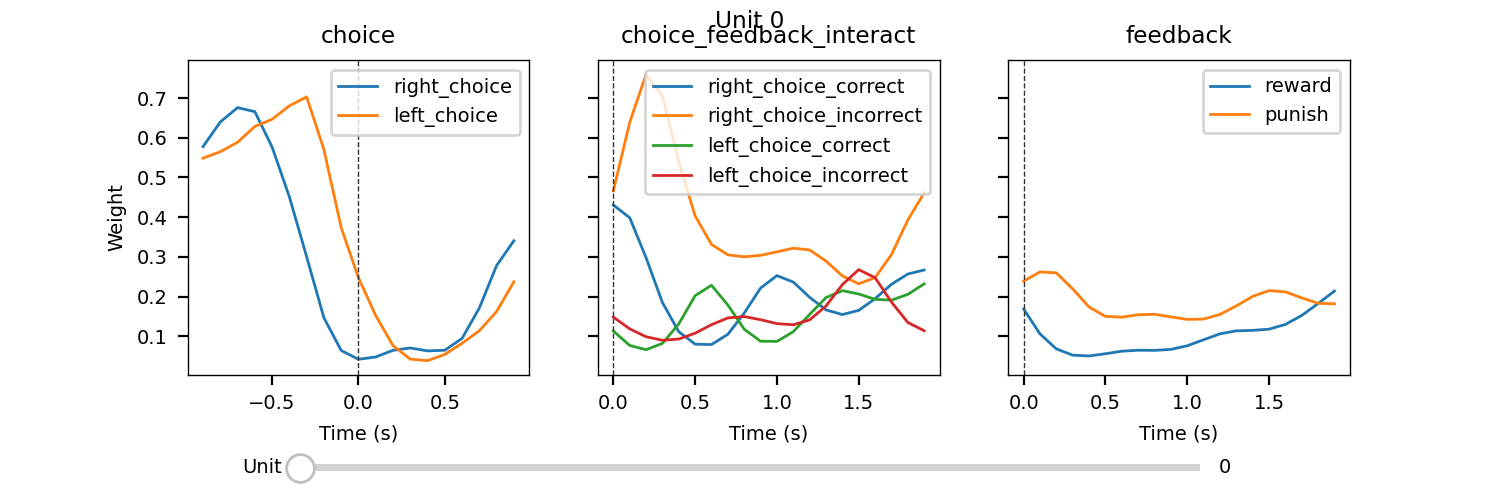

In [ ]:
r_kernel = KernelRenderer(model, dmat, bias)
viewer_kernels = NeuronViewer(num_units=peth.shape[0], render_func=r_kernel, ncols=len(r_kernel.all_tags))


In [14]:
all_tags = np.ravel([reg.tags for _, reg in dmat.regressors.items()])
all_tags

array([{'task', 'choice'}, {'task', 'choice'}, {'feedback', 'task'},
       {'feedback', 'task'},
       {'task', 'choice_feedback_interact', 'interaction'},
       {'task', 'choice_feedback_interact', 'interaction'},
       {'task', 'choice_feedback_interact', 'interaction'},
       {'task', 'choice_feedback_interact', 'interaction'},
       {'sigmoid', 'hmm'}, {'sigmoid', 'hmm'}, {'sigmoid', 'hmm'}],
      dtype=object)

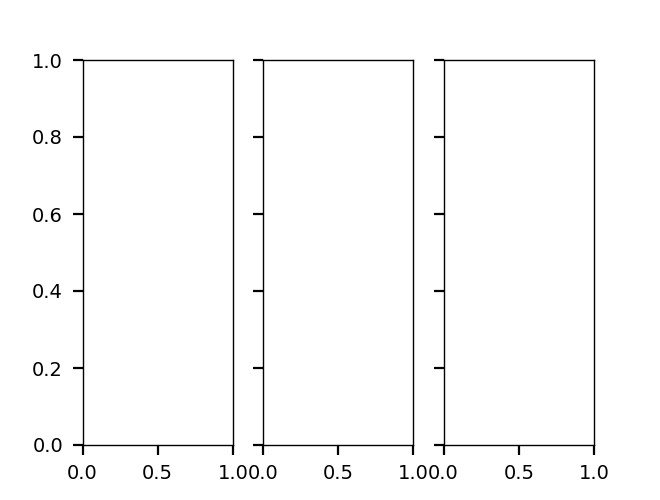

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=1, sharey=True)

ax[0].plot(np.arange(30))
ax[0].set_ylim(0, 50)
for a in ax: a.clear()

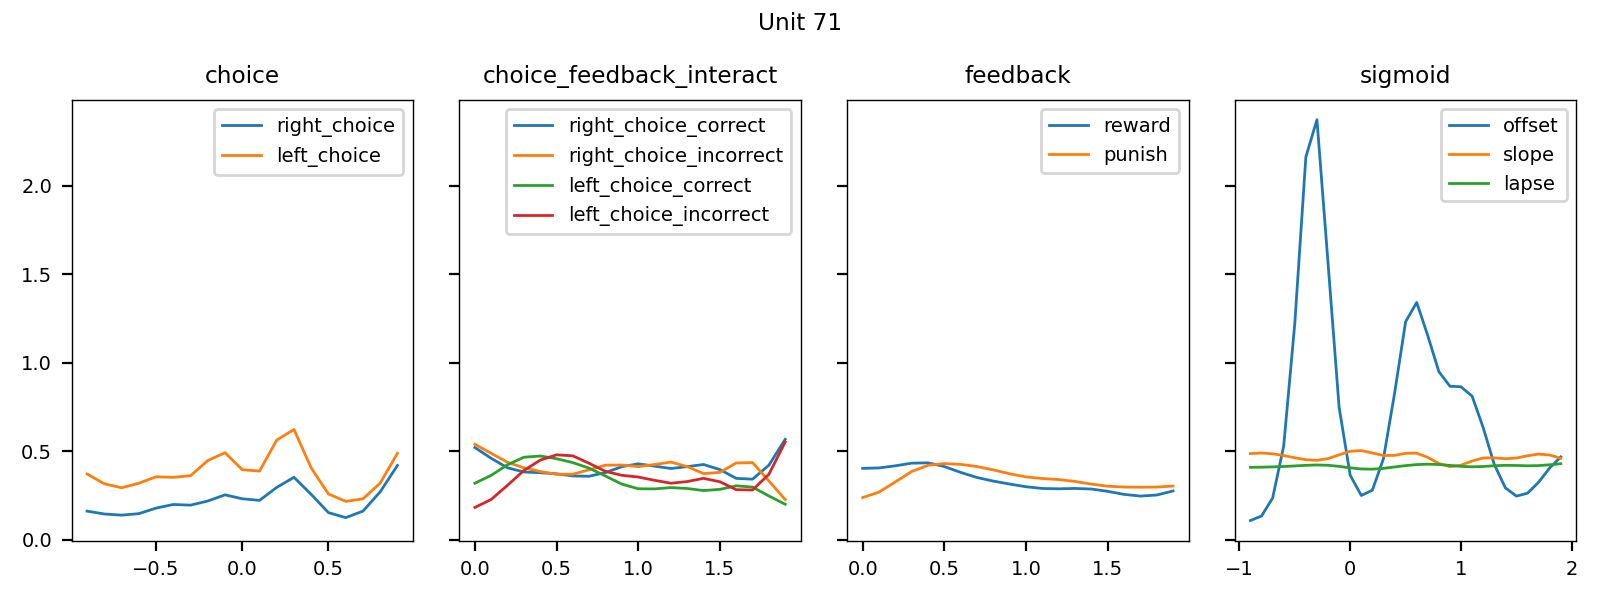

In [11]:
# plot kernels
ind = 71

def plot_kernels(idx):
    linkfunc = model.estimators_[0]._base_loss.link.inverse
    # get the unique tags from dmat
    all_tags = []
    for regname,reg in dmat.regressors.items():
        all_tags.extend(reg.tags)
    all_tags = np.unique(all_tags)
    all_tags = [t for t in all_tags if t not in ['task', 'interaction', 'hmm']]

    # make subplots for each tag
    fig, axs = plt.subplots(1,len(all_tags), figsize=(8,3), sharey=True)
    if len(all_tags) == 1:
        axs = [axs]

    for i,tag in enumerate(all_tags):
        regs = dmat.select(tag=tag)
        for r,reg in regs.items():
            k,t = reg.reconstruct_kernel()
            k = k[:,idx]
            k = linkfunc(k + bias[idx])
            axs[i].plot(t, k, label=reg.name)
        axs[i].set_title(tag)
        if tag not in ['history','dlc','video']:
            axs[i].legend()

    fig.suptitle(f"Unit {idx}")
    fig.tight_layout()
plot_kernels(ind)

In [ ]:
from damn.scoring import bits_per_spike_multi_target
bits_per_spike_multi_target(Y, Yhat)

In [ ]:
# check best alpha for single cells
from damn.scoring import bits_per_spike
from sklearn.model_selection import train_test_split
ind = -4
alphas = np.logspace(-8, 0, 10)
scores = []

Xsmall = X[:1000]
Ysmall = Y[:1000,ind]

for a in tqdm(alphas):
    model = PoissonRegressor(alpha=a, max_iter=10000)
    # randomly split into train and test
    model.fit(Xsmall, Ysmall)
    Y_pred = model.predict(Xsmall)
    scores.append(bits_per_spike(Ysmall, Y_pred))

best_alpha = alphas[np.argmax(scores)]

In [ ]:
best_alpha # seems like 1e-5 to 1e-6

In [ ]:
plt.figure()
plt.plot(alphas,scores)
plt.xscale('log')
plt.show()

In [ ]:
from sklearn.linear_model import PoissonRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import make_scorer
from damn.scoring import bits_per_spike_multi_target

base_model = PoissonRegressor(max_iter=1000)
multi_model = MultiOutputRegressor(base_model)

param_dist = {
    "estimator__alpha": loguniform(1e-6, 1e2)  # IMPORTANT: prefix with estimator__
}

scorer = make_scorer(
    bits_per_spike,
    greater_is_better=True
)
scorer = 'neg_mean_poisson_deviance'

search = RandomizedSearchCV(
    multi_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=scorer,
    #n_jobs=-1,
)

search.fit(X, Y)   # Y shape (n_samples, n_outputs)